In [321]:
import pickle
import glob
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import numpy as np
import os

In [322]:
# Antonio - Unibo

output_dir = "/home/aguastella/fl_powerpropagation/outputs/"
# day = "2024-09-29"
time = "08-50-34"
global_masks_dir = "/working/global_masks"


# lr0.5
# lda0.1
day = "2024-09-29"
time = "2024-09-29/08-50-34"  # zerofl cifar10 s0.95
time = "2024-09-29/10-27-45"  # topk cifar10 s0.95
time = "2024-09-29/11-20-18"  # pp cifar100 s0.95
time = "2024-09-29/12-19-22"  # zerofl cifar100 s0.9
time = "2024-09-29/13-58-20"  # topk cifar100 s0.9
time = "2024-09-29/14-51-35"  # pp cifar10 s0.9
time = "2024-09-29/16-02-43"  # pp cifar10 s0.95
time = "2024-09-29/17-01-47"  # zerfl cifar10 s0.9
time = "2024-09-29/18-40-46"  # pp cifar100 s0.9
time = "2024-09-29/19-40-30"  # zerofl cifar100 s0.95
time = "2024-09-29/06-04-19"  # topk cifar100 s0.95
time = "2024-09-29/06-57-35"  # topk cifar100 s0.9

# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/08-50-34/working/global_masks" # zerofl cifar10
# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/10-27-45/working/global_masks" # topk cifar10
# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/11-20-18/working/global_masks" # pp cifar100
# directory_path =  "/home/aguastella/fl_powerpropagation/outputs/2024-09-29/12-19-22/working/global_masks" # zerofl cifar100
directory_path = output_dir + day + "/" + time + global_masks_dir

In [323]:
pp_cifar10_s095 = "16-02-43"  # pp cifar10 s0.95
topk_cifar10_s095 = "10-27-45"  # topk cifar10 s0.95
zerofl_cifar10_s095 = "08-50-34"  # zerofl cifar10 s0.95

pp_cifar10_s09 = "14-51-35"  # pp cifar10 s0.9
topk_cifar10_s09 = "06-57-35"  # topk cifar10 s0.9
zerofl_cifar10_s09 = "17-01-47"  # zerfl cifar10 s0.9

pp_cifar100_s095 = "11-20-18"  # pp cifar100 s0.95
topk_cifar100_s095 = "06-04-19"  # topk cifar100 s0.95
zerofl_cifar100_s095 = "19-40-30"  # zerofl cifar100 s0.95

pp_cifar100_s09 = "18-40-46"  # pp cifar100 s0.9
topk_cifar100_s09 = "13-58-20"  # topk cifar100 s0.9
zerofl_cifar100_s09 = "12-19-22"  # zerofl cifar100 s0.9

In [324]:
time_dict = {
    # "pp_cifar10_s09":           "2024-09-29/14-51-35",
    # "topk_cifar10_s09":         "2024-09-29/06-57-35",
    # "zerofl_cifar10_s09":       "2024-09-29/17-01-47",
    # "SparsyFed_cifar10_s095":   "2024-09-29/16-02-43",
    # "topk_cifar10_s095":        "2024-09-29/10-27-45",
    # "zerofl_cifar10_s095":      "2024-09-29/08-50-34",
    # "SparsyFed_cifar10_s099":   "2024-09-30/13-46-12",
    # "topk_cifar10_s099":        "2024-09-30/12-57-20",
    # "zero_fl_cifar10_s099":     "2024-09-30/10-20-03",
    "SparsyFed_cifar100_s09": "2024-09-29/18-40-46",
    "topk_cifar100_s09": "2024-09-29/13-58-20",
    "zerofl_cifar100_s09": "2024-09-29/12-19-22",
    "pp_cifar100_s095": "2024-09-29/11-20-18",
    "topk_cifar100_s095": "2024-09-29/06-04-19",
    "zerofl_cifar100_s095": "2024-09-29/19-40-30",
    "Sparsyfed_cifar100_s099": "2024-09-30/10-21-08",
    "topk_cifar100_s099": "2024-09-30/09-28-56",
    "zerofl_cifar100_s099": "2024-09-30/07-50-52",
}

In [325]:
sampling_rate = 10


def extract_numbers(filename):
    match = re.search(r"mask_(\d+)_client_(\d+)", filename)
    if match:
        mask_num = int(match.group(1))
        client_num = int(match.group(2))
        return mask_num, client_num
    return None, None


def load_masks(directory_path):
    pickle_files = glob.glob(f"{directory_path}/mask_*.pickle")
    pickle_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

    masks = []
    for file in pickle_files:
        with open(file, "rb") as f:
            mask = pickle.load(f)
            masks.append((os.path.basename(file), mask))

    return masks


def remove_initial_masks(all_masks):
    for key in all_masks:
        if len(all_masks[key]) > 0:
            # Remove mask_0 if present
            if all_masks[key][0][0].startswith("mask_0."):
                print(f"Removing mask_0 from {key}")
                all_masks[key].pop(0)

            # Remove mask_1 if present
            if all_masks[key][0][0].startswith("mask_1."):
                print(f"Removing mask_1 from {key}")
                all_masks[key].pop(0)

    return all_masks


# Load masks for each run
all_masks = {}
for key, time in time_dict.items():
    directory_path = f"{output_dir}/{time}{global_masks_dir}"
    # print(f"Loading masks for {key}:")
    all_masks[key] = load_masks(directory_path)
    # print(f"Loaded {len(all_masks[key])} masks for {key}")
    # print()

# Remove initial masks (0 and 1) if present
all_masks = remove_initial_masks(all_masks)

# Print final mask counts
# for key in all_masks:
#     print(f"Final count for {key}: {len(all_masks[key])} masks")

# Separate filenames and mask data
for key in all_masks:
    all_masks[key] = [mask for _, mask in all_masks[key]]

# print("Mask data separated from filenames.")

Removing mask_0 from pp_cifar10_s09
Removing mask_0 from topk_cifar10_s09
Removing mask_0 from zerofl_cifar10_s09
Removing mask_0 from SparsyFed_cifar10_s095
Removing mask_0 from zerofl_cifar10_s095
Removing mask_0 from topk_cifar10_s099
Removing mask_0 from SparsyFed_cifar100_s09
Removing mask_0 from topk_cifar100_s09
Removing mask_0 from zerofl_cifar100_s09
Removing mask_0 from topk_cifar100_s095
Removing mask_0 from zerofl_cifar100_s095
Removing mask_0 from Sparsyfed_cifar100_s099
Removing mask_0 from topk_cifar100_s099
Removing mask_0 from zerofl_cifar100_s099


COnseguent rounds overlap

In [326]:
# # Compute overlap percentage between consecutive masks
# overlap_percentages = [
#     intersection_over_union(masks[i], masks[i + 1]) for i in range(len(masks) - 1)
# ]

# # Plot overlap percentage over time
# rounds = range(1, len(overlap_percentages) + 1)
# plt.figure(figsize=(10, 6))
# plt.plot(rounds, overlap_percentages, marker="o")
# plt.xlabel("Training Round")
# plt.ylabel("Overlap Percentage")
# plt.title("Overlap Percentage of Weights During Training")
# plt.grid(True)
# plt.ylim(0, 1.0)  # Set the y-axis limits
# plt.tight_layout()
# plt.show()

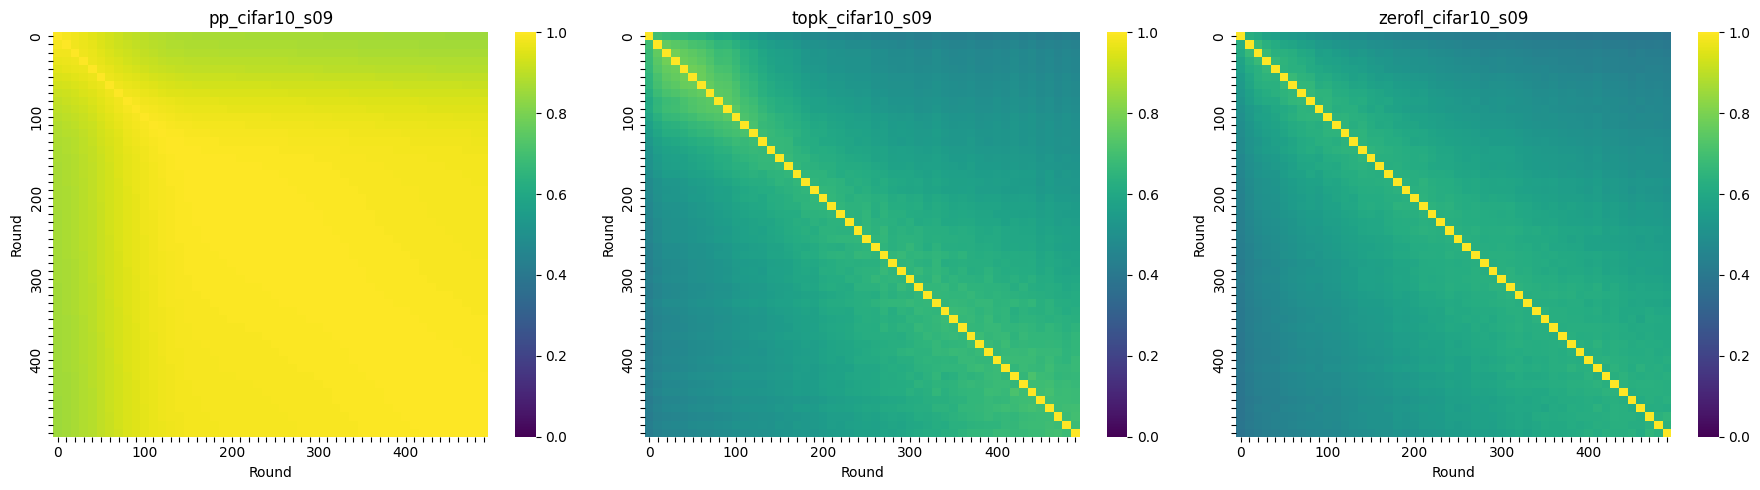

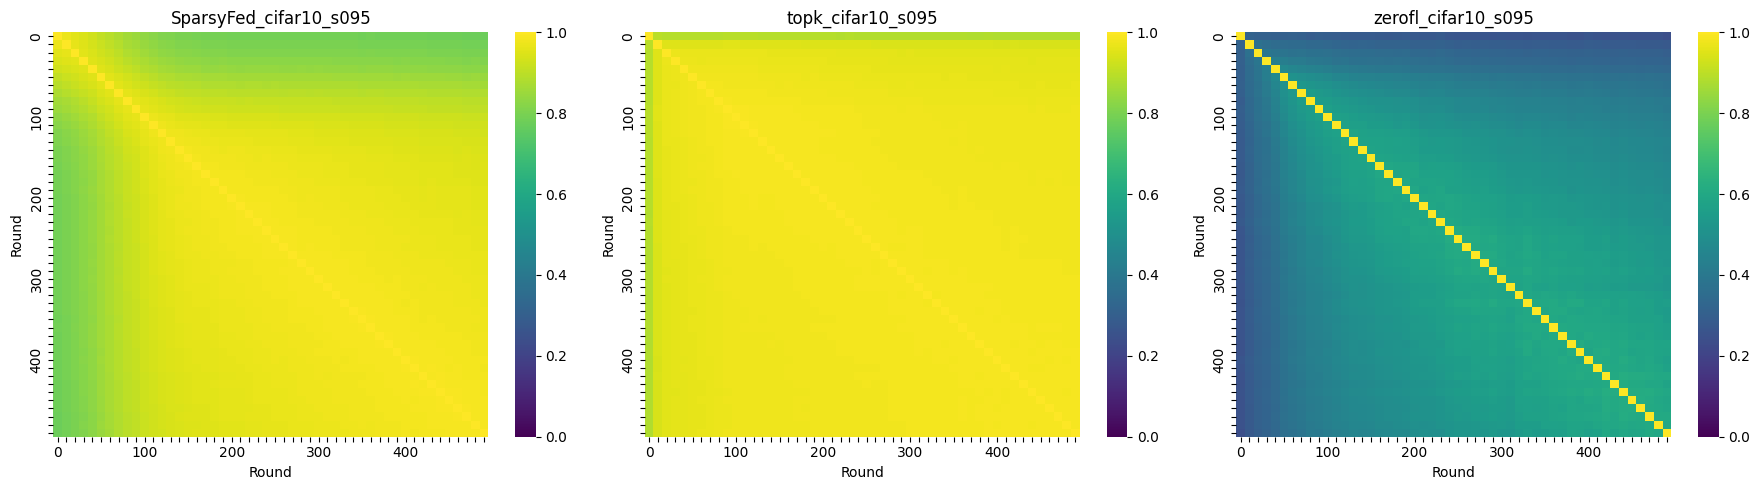

/home/aguastella/.cache/pypoetry/virtualenvs/project-BJXYtbZX-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/aguastella/.cache/pypoetry/virtualenvs/project-BJXYtbZX-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/aguastella/.cache/pypoetry/virtualenvs/project-BJXYtbZX-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/aguastella/.cache/pypoetry/virtualenvs/project-BJXYtbZX-py3.11/lib/python3.1

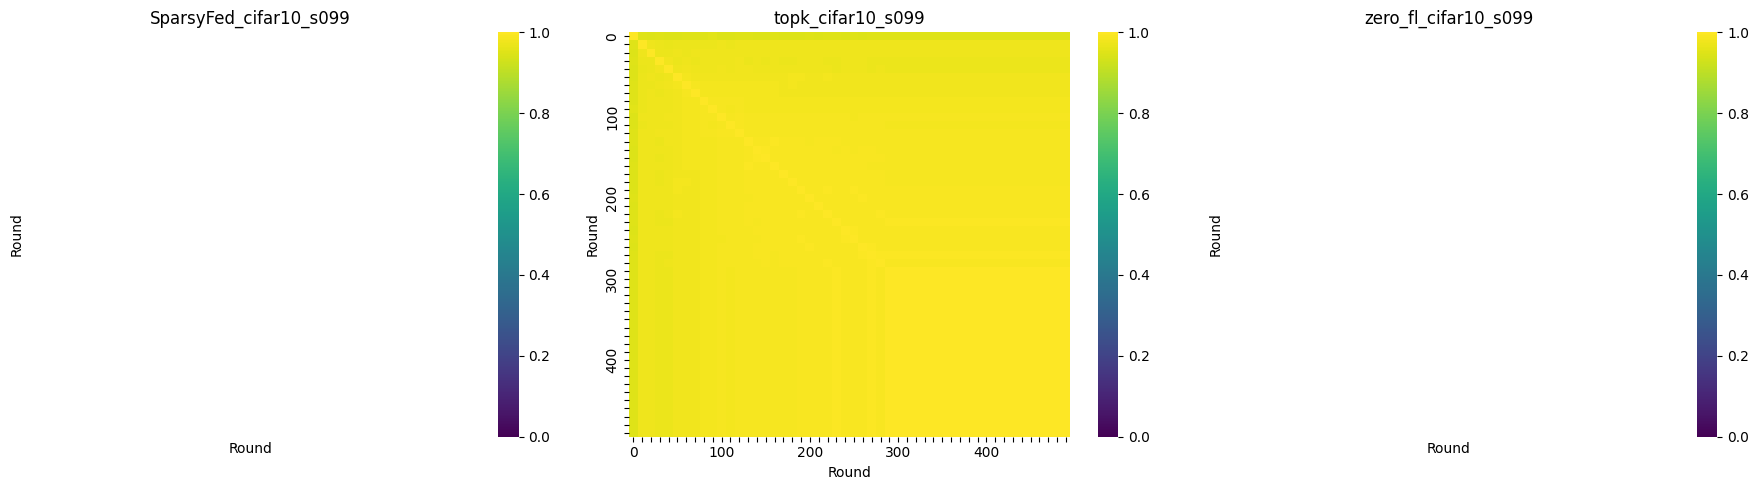

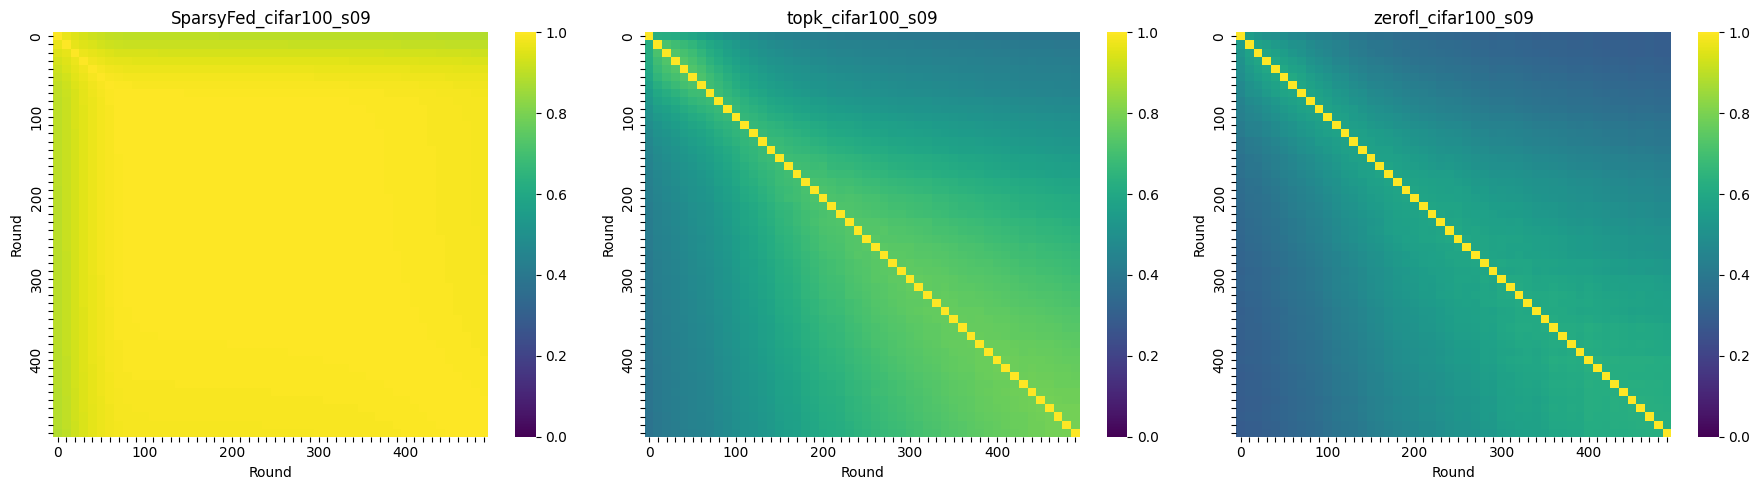

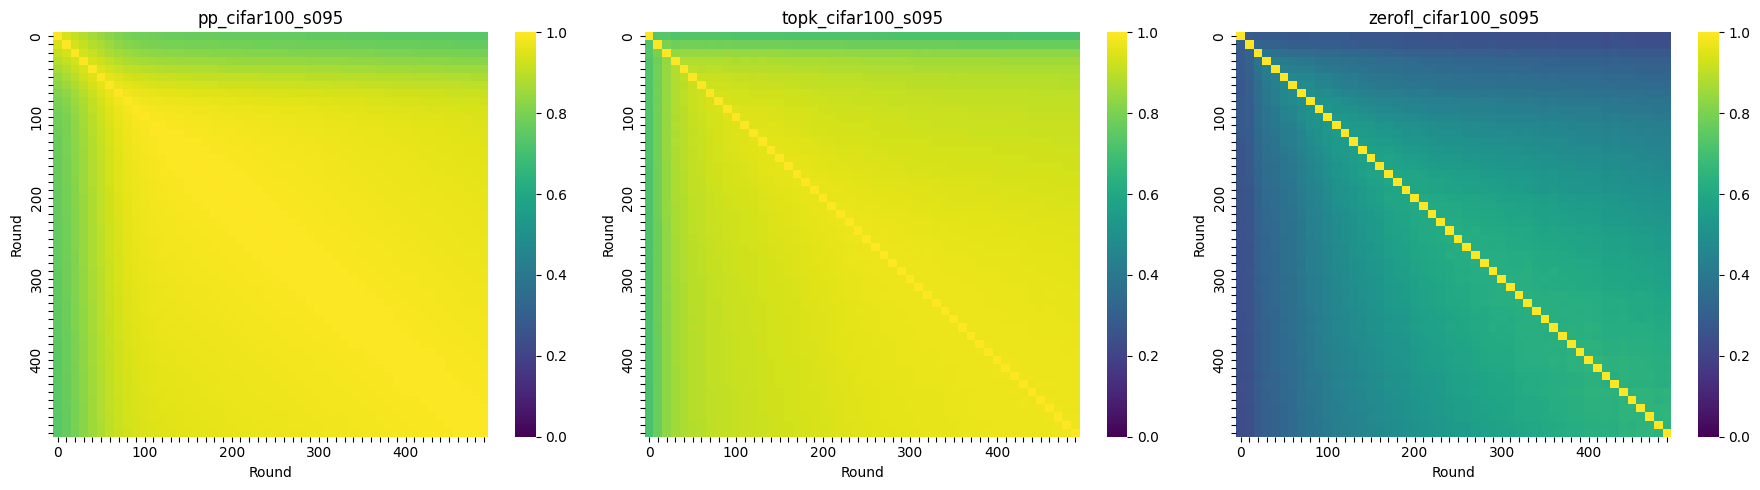

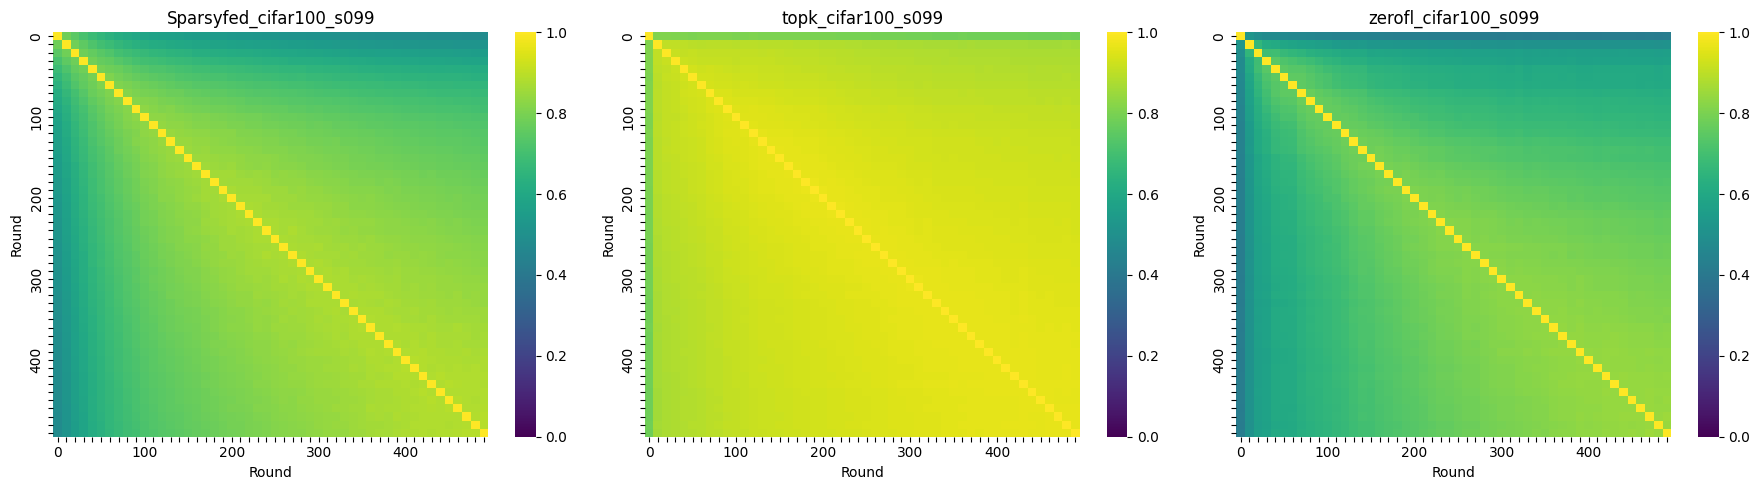

In [327]:
def intersection_over_union(mask1, mask2):
    intersection = sum(np.sum(m1 & m2) for m1, m2 in zip(mask1, mask2))
    union = sum(np.sum(m1 | m2) for m1, m2 in zip(mask1, mask2))
    return intersection / union


def compute_overlap_matrix(masks):
    num_masks = len(masks)
    overlap_matrix = np.zeros((num_masks, num_masks))

    def compute_overlap(i, j):
        overlap_matrix[i, j] = intersection_over_union(masks[i], masks[j])

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(num_masks):
            for j in range(i):
                futures.append(executor.submit(compute_overlap, i, j))
        concurrent.futures.wait(futures)

    np.fill_diagonal(overlap_matrix, 1.0)
    for i in range(num_masks):
        for j in range(i):
            overlap_matrix[j, i] = overlap_matrix[i, j]

    return overlap_matrix


# Function to plot three runs at a time
def plot_three_runs(runs_data, start_index):
    num_runs = len(all_masks)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (key, masks) in enumerate(
        list(runs_data.items())[start_index : start_index + 3]
    ):
        if idx >= 3:  # Ensure we only plot 3 at a time
            break

        overlap_matrix = compute_overlap_matrix(masks)
        num_masks = len(masks)

        sns.heatmap(
            overlap_matrix,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            xticklabels=[
                label * sampling_rate if label % 10 == 0 else ""
                for label in range(num_masks)
            ],
            yticklabels=[
                label * sampling_rate if label % 10 == 0 else ""
                for label in range(num_masks)
            ],
            vmin=0,
            vmax=1.0,
            ax=axes[idx],
        )
        axes[idx].set_title(key)
        axes[idx].set_xlabel("Round")
        axes[idx].set_ylabel("Round")

    plt.tight_layout()
    plt.show()


# Plot all runs, three at a time
num_runs = len(all_masks)
for i in range(0, num_runs, 3):
    plot_three_runs(all_masks, i)

In [328]:
# import concurrent.futures
# import multiprocessing
# import numpy as np
# import ctypes
# from multiprocessing import sharedctypes


# def intersection_over_union(mask1, mask2):
#     # Dummy implementation
#     intersection = np.minimum(mask1, mask2).sum()
#     union = np.maximum(mask1, mask2).sum()
#     return intersection / union

# # Compute overlap percentage matrix
# num_masks = len(masks)
# overlap_matrix = np.zeros((num_masks, num_masks))

# # Create shared memory arrays
# shared_array_base = sharedctypes.RawArray(ctypes.c_double, num_masks * num_masks * len(masks[0]))
# overlap_matrix_layer = np.ctypeslib.as_array(shared_array_base)
# overlap_matrix_layer = overlap_matrix_layer.reshape(len(masks[0]), num_masks, num_masks)

# def compute_overlap_for_batch(batch, masks):
#     local_overlap_matrix_layer = np.zeros((len(masks[0]), num_masks, num_masks))
#     for i, j in batch:
#         for k in range(len(masks[0])):
#             if (
#                 masks[i][k].shape != (10,)
#                 and masks[i][k].shape != (64,)
#                 and masks[i][k].shape != ()
#                 and masks[i][k].shape != (128,)
#                 and masks[i][k].shape != (256,)
#                 and masks[i][k].shape != (512,)
#             ):
#                 local_overlap_matrix_layer[k, i, j] = intersection_over_union(
#                     masks[i][k], masks[j][k]
#                 )
#     return local_overlap_matrix_layer

# def parallel_computation(num_masks, masks, batch_size=10):
#     with concurrent.futures.ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
#         futures = []
#         # Create batches of (i, j) pairs
#         batches = [(i, j) for i in range(num_masks) for j in range(i)]
#         for batch_start in range(0, len(batches), batch_size):
#             batch = batches[batch_start:batch_start + batch_size]
#             futures.append(executor.submit(compute_overlap_for_batch, batch, masks))

#         for future in concurrent.futures.as_completed(futures):
#             local_overlap_matrix_layer = future.result()
#             overlap_matrix_layer += local_overlap_matrix_layer

#     # Set the diagonal of overlap_matrix_layer to 1.0
#     for k in range(len(masks[0])):
#         np.fill_diagonal(overlap_matrix_layer[k], 1.0)

#     # Fill the second half of the matrix
#     for i in range(num_masks):
#         for j in range(i):
#             overlap_matrix_layer[:, j, i] = overlap_matrix_layer[:, i, j]

#     return overlap_matrix_layer

# # Execute the parallel computation
# overlap_matrix_layer = parallel_computation(num_masks, masks)

In [329]:
# import concurrent.futures
# import multiprocessing

# # if m.shape != (10, ) and m.shape != (64, ) and m.shape != () and m.shape != (128,) and m.shape != (256,) and m.shape != (512,):

# # Compute overlap percentage matrix
# num_masks = len(masks)
# overlap_matrix = np.zeros((num_masks, num_masks))
# overlap_matrix_layer = np.zeros((len(masks[0]), num_masks, num_masks))


# def intersection_over_union(mask1, mask2):
#     # Vectorized implementation of intersection over union
#     intersection = np.logical_and(mask1, mask2).sum()
#     union = np.logical_or(mask1, mask2).sum()
#     return intersection / union


# def compute_overlap(i, j):
#     # overlap_matrix[i, j] = compute_overlap_percentage(masks[i], masks[j])
#     # overlap_matrix[i, j] = intersection_over_union(masks[i], masks[j])

#     for k in range(len(masks[0])):
#         if (
#             masks[i][k].shape != (10,)
#             and masks[i][k].shape != (64,)
#             and masks[i][k].shape != ()
#             and masks[i][k].shape != (128,)
#             and masks[i][k].shape != (256,)
#             and masks[i][k].shape != (512,)
#         ):
#             overlap_matrix_layer[k, i, j] = intersection_over_union(
#                 masks[i][k], masks[j][k]
#             )


# # Use multi-threading to parallelize the computation
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     # with concurrent.futures.ProcessPoolExecutor() as executor:
#     futures = []
#     for i in range(num_masks):
#         for j in range(i):
#             futures.append(executor.submit(compute_overlap, i, j))
#     # Wait for all computations to complete
#     concurrent.futures.wait(futures)


# # Set the diagonal of overlap_matrix_layer to 1.0
# for i in range(len(masks[0])):
#     np.fill_diagonal(overlap_matrix_layer[i], 1.0)
# # Fill the second half of the matrix
# for i in range(num_masks):
#     for j in range(i):
#         overlap_matrix_layer[:, j, i] = overlap_matrix_layer[:, i, j]

In [330]:
# PLOTS FOR EACH LAYER, DIVIDED

# for i in range(len(masks[0])):
#     if masks[0][i].shape != (10, ) and masks[0][i].shape != (64, ) and masks[0][i].shape != () and masks[0][i].shape != (128,) and masks[0][i].shape != (256,) and masks[0][i].shape != (512,):
#         # Plot heatmap
#         plt.figure(figsize=(5,4))
#         sns.heatmap(
#         overlap_matrix_layer[i],
#         annot=False,
#         fmt=".2f",
#         cmap="viridis",
#         xticklabels='',
#         # xticklabels=range(num_masks),
#         yticklabels='',
#         # yticklabels=range(num_masks),
#         )
#         # plt.xlabel("Round")
#         # plt.ylabel("Round")
#         plt.title(f"Layer {i}, shape {masks[0][i].shape}")
#         plt.tight_layout()
#         plt.show()

# # # Plot heatmap
# # plt.figure(figsize=(3,3))
# # sns.heatmap(
# # overlap_matrix_layer[0],
# # annot=False,
# # fmt=".2f",
# # cmap="viridis",
# # xticklabels=range(num_masks),
# # yticklabels=range(num_masks),
# # )
# # # plt.xlabel("Round")
# # # plt.ylabel("Round")
# # plt.tight_layout()
# # plt.show()

In [331]:
# # import matplotlib.pyplot as plt
# # import seaborn as sns
# # import numpy as np

# # Assuming overlap_matrix_layer and masks are defined earlier in the code

# def plot_layers_heatmap(masks):
#     # Determine the number of heatmaps to plot
#     num_heatmaps = sum(
#         1
#         for i in range(len(masks[0]))
#         if masks[0][i].shape not in [(10,), (64,), (), (128,), (256,), (512,)]
#     )

#     # Calculate the grid size for subplots
#     cols = 3  # You can change this to the desired number of columns
#     rows = int(np.ceil(num_heatmaps / cols))

#     # Create subplots
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))

#     # Flatten axes for easy iteration
#     axes = axes.flatten()

#     # Plot each heatmap
#     plot_index = 0
#     tot_nz = np.sum(m.size for m in masks[-1])
#     print(f"Total elements in the last mask: {tot_nz}")

#     tot_layer_nz = 0
#     for i in range(len(masks[0])):
#         if masks[0][i].shape not in [(10,), (64,), (), (128,), (256,), (512,)]:
#             # count the number of non-zero elements of a mask
#             tot_layer_nz += round(masks[-1][i].size / tot_nz * 100, 2)
#             sns.heatmap(
#                 overlap_matrix_layer[i],
#                 annot=False,
#                 fmt=".2f",
#                 cmap="viridis",
#                 xticklabels="",
#                 yticklabels="",
#                 vmin=0,
#                 vmax=1.0,
#                 ax=axes[plot_index],
#             )
#             axes[plot_index].set_title(
#                 f"Layer{i}, size:{masks[0][i].size},"
#                 f" importance:{round(masks[-1][i].size/tot_nz*100, 2)}%,"
#                 f" nz:{round(np.sum(masks[-1][i])/masks[0][i].size*100, 2)}%"
#             )
#             plot_index += 1

#     print(f"Total non-zero elements in the last mask: {tot_layer_nz}")

#     # Remove any unused subplots
#     for j in range(plot_index, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

# # plot_layers_heatmap(masks)